In [89]:
import pandas as pd
import os
import numpy as np
from math import sqrt

In [5]:
root = '../../../dumps/mp'

In [10]:
def get_csvs():
    res = {}
    for p in os.listdir(root):
        res[p] = {}
        for run in os.listdir(os.path.join(root, p)):
            res[p][run] = {}
            for tag in os.listdir(os.path.join(root, p, run)):
                res[p][run][tag] = pd.read_csv(os.path.join(root, p, run, tag, 'ratio.csv'))
    return res

In [22]:
def average_runs(csvs):
    res = {}
    for p, runs_with_p in csvs.items():
        runs_summed = {}
        for run in runs_with_p.values():
            for tag, table in run.items():
                n_layer = table.shape[-1] - 2
                if tag not in runs_summed:
                    runs_summed[tag] = table
                else:
                    runs_summed[tag].iloc[:, -n_layer:] = runs_summed[tag].iloc[:, -n_layer:].add(table.iloc[:, -n_layer:], fill_value=0)
        runs_averaged = runs_summed
        for tag in runs_summed:
            runs_averaged[tag].iloc[:, -n_layer:] /= len(runs_with_p.values())
        res[p] = runs_summed
    return res

In [92]:
def get_ps_tags_and_steps(csvs):
    p, runs_with_p = next(iter(csvs.items()))
    tags = list(runs_with_p.keys())
    
    table = next(iter(runs_with_p.values()))
    steps = table.iloc[:, 1].to_numpy()
    return [int(k) for k in csvs.keys()], tags, steps

In [166]:
csvs = get_csvs() # [p, runs, tag]
csvs = average_runs(csvs) # [p, tag]
ps, tags, steps = get_ps_tags_and_steps(csvs)

In [167]:
def pad(data, index, length):
    pad_values = [(0, 0) for i in range(len(data.shape))]
    pad_values[index] = (0, length - data.shape[-2])
    return np.pad(data, pad_values)

def get_ndarray(csvs):
    """p tag step layer
    """
    array = []
    max_steps = 0
    for p, records_with_p in csvs.items():
        data_with_p = []
        for tag, table in records_with_p.items():
            data = table.iloc[:, 2:].to_numpy()
            data_with_p.append(data)
            max_steps = max(max_steps, data.shape[0])
        for i, data in enumerate(data_with_p):
            data_with_p[i] = pad(data, -2, max_steps)
        array.append(np.array(data_with_p))
    for i, data in enumerate(array):
        array[i] = pad(data, -2, max_steps)
    array = np.array(array)
    return array

In [168]:
array = get_ndarray(csvs)

In [169]:
global_indices = [i for i, tag in enumerate(tags) if 'global' in tag]
global_tags = [tag for tag in tags if 'global' in tag]
global_statistics = array[:, global_indices]
global_statistics.shape

(10, 4, 9375, 4)

In [170]:
import torch

def compute_bounds(array: torch.Tensor, ps: torch.Tensor, tags: 'list[str]', steps: torch.Tensor, type: str, batchsize=32, v=1e-2):
    """
        array: [p, tag, step, layer]
        res:   [p,      step, layer] 
    """
    def get_index(keyword):
        for i, tag in enumerate(tags):
            if keyword in tag:
                return i
        assert False, (keyword, tags)
    anisotropy = array[:, get_index(type + '_global_anisotropy')]
    alpha = array[:, get_index(type + '_global_alpha')]
    c = ps.unsqueeze(dim=-1).unsqueeze(dim=-1) / (steps * batchsize).unsqueeze(dim=0).unsqueeze(dim=-1)
    common = (c + (2 * sqrt(2) + 3) * c * alpha / v + c * anisotropy / v + c / (v * ps.unsqueeze(dim=-1).unsqueeze(dim=-1))).sqrt()
    bound_im = sqrt(2) / (c * v * sqrt(v)) * (alpha ** 2) * common
    bound_re = sqrt(2) / (c * sqrt(v)) * alpha * common
    return bound_im, bound_re

In [171]:
# 均值随着 p 的变化
tendency_along_p = global_statistics.mean(axis=(-1, -2))

In [172]:
bound_im, bound_re = compute_bounds(torch.tensor(array), torch.tensor(ps), tags, torch.tensor(steps), 'sample', v=1e-2)

In [173]:
import matplotlib.pyplot as plt
def plot_curves(x, y, labels, y_logscale=False, sort_x=False, xlabel=None, ylabel=None, figsize=(9, 6), savepath=None):
    """
    Plot multiple curves on the same figure.

    Parameters:
    - x: 1D ndarray or torch.Tensor for x-axis data.
    - y: 2D ndarray or torch.Tensor where the first dimension distinguishes different curves.
    - labels: List of string labels for the curves.
    """

    # Ensure x and y are numpy arrays (if they're torch Tensors)
    if isinstance(x, torch.Tensor):
        x = x.numpy()
    if isinstance(y, torch.Tensor):
        y = y.numpy()

    if sort_x:
        sort_indices = np.argsort(x)
        x = x.ravel()[sort_indices]
        y = y[:, sort_indices]

    # Combine labels and curves for sorting
    curves_with_labels = zip(labels, y)
    
    # Sort based on curve name
    sorted_curves_with_labels = sorted(curves_with_labels, key=lambda curve: curve[0])
    sorted_labels, sorted_curves = zip(*sorted_curves_with_labels)
    
    # Number of curves to plot
    num_curves = len(sorted_curves)

    # Get viridis color map
    colors = plt.cm.viridis(np.linspace(0, 1, num_curves))

    # Plot each curve with a unique color from the viridis palette
    for i in range(num_curves):
            plt.plot(x, sorted_curves[i], color=colors[i], label=sorted_labels[i])
    if y_logscale:
        plt.yscale('log')

    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    # Place the legend outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    else:
        plt.show()


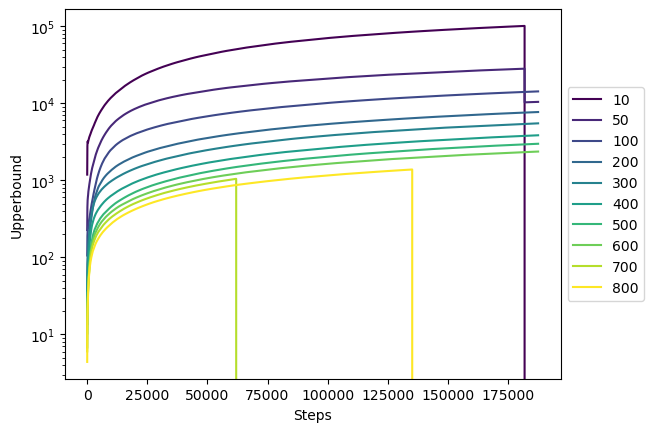

In [174]:
plot_curves(steps, bound_re[..., 1], [p for p in ps], y_logscale=True, xlabel="Steps", ylabel="Upperbound")

In [175]:
def formal_name(name: str):
    if isinstance(name, list):
        return [formal_name(n) for n in name]
    name = name[name.find("]") + 1:]
    name = name.replace("global", "")
    name = name.replace("__", " ")
    tokens = name.split(" ")
    tokens = [ token[0].capitalize() + token[1:] for token in tokens]
    return ' '.join(tokens)

formal_name(global_tags)

['Sample Anisotropy', 'Gradient Anisotropy', 'Sample Alpha', 'Gradient Alpha']

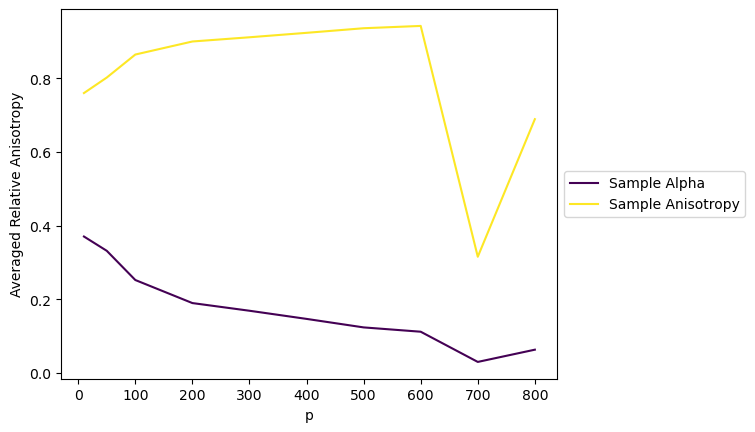

In [176]:
sample_tags = [tag for tag in global_tags if 'sample' in tag]
sample_tendency_along_p = tendency_along_p[:, [i for i, tag in enumerate(global_tags) if 'sample' in tag]]
plot_curves(np.array([int(p) for p in ps]), torch.tensor(sample_tendency_along_p).transpose(0, 1), formal_name(sample_tags), sort_x=True, xlabel="p", ylabel="Averaged Relative Anisotropy")

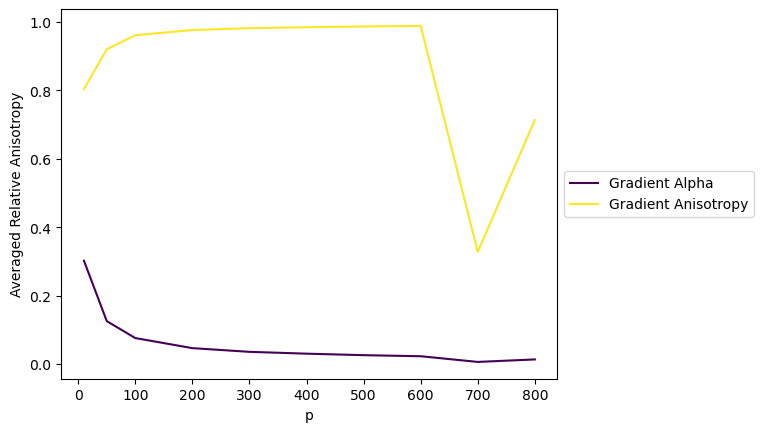

In [177]:
gradient_tags = [tag for tag in global_tags if 'gradient' in tag]
gradient_tendency_along_p = tendency_along_p[:, [i for i, tag in enumerate(global_tags) if 'gradient' in tag]]
plot_curves(np.array([int(p) for p in ps]), torch.tensor(gradient_tendency_along_p).transpose(0, 1), formal_name(gradient_tags), sort_x=True, xlabel="p", ylabel="Averaged Relative Anisotropy")